## 1. Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import feature_extraction, linear_model, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## 2. Load data

In [ ]:
df = pd.read_csv('data_final.csv')
df.head()

,Content,Historia,Kosmos,Ludzie,Nauka,Odkrycia,Przyroda
0,morza i oceany często są porównywane do przest...,0.0,0.0,0.0,0.0,0.0,1.0
1,ziemia powstała z mgławicy słonecznej ok mld ...,0.0,0.0,0.0,1.0,1.0,0.0
2,meteoroidy to krążące po kosmosie kawałki skał...,0.0,1.0,0.0,0.0,0.0,0.0
3,w programie edycji znalazła się min sekcja bi...,0.0,0.0,1.0,0.0,0.0,0.0
4,wszyscy dobrze wiemy jakie odgłosy wydają świn...,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
def get_stopwords_list(stop_file_path):  
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))

In [ ]:
# Source: https://www.kaggle.com/datasets/heeraldedhia/stop-words-in-28-languages

stopwords = get_stopwords_list('polish.txt')
print(len(stopwords))
print(stopwords[:10])

335
['bardzo', 'czy', 'ich', 'lub', 'tak', 'sobie', 'totobą', 'nowe', 'aj', 'innych']


In [ ]:
def remove_stop_words(corpus):
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stopwords:
            if stop_word in tmp:
                tmp = [value for value in tmp if value != stop_word]
        results.append(" ".join(tmp))      
    return results

df['Content'] = remove_stop_words(df['Content'])

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
X_train = train['Content']
X_test = test['Content']
y_train  = train.loc[:, train.columns != 'Content']
y_test  = test.loc[:, test.columns != 'Content']

In [ ]:
X_train

678    osób decyduje ograniczenie mięsa diecie przejś...
793    erupcje wulkanów wpływają życie mieszkańców za...
90     mała epoka lodowa nastąpiła okresie zwanego śr...
826    najważniejszych odkryć dekady naukowcy badając...
181    temat ufo budzi wielkie emocje szczególnie fan...
                             ...                        
106    dawniej wszelkie niecodzienne zjawiska występu...
270    çatalhöyük prawdopodobnie najstarszych zarazem...
860    analizy dziennikarzy brytyjskiego magazynu the...
435    koloseum obiekt wzbudza skrajne emocje jednej ...
102    toxoplasma gondii pierwotniak nowej klasyfikac...
Name: Content, Length: 617, dtype: object

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((617,), (617, 6), (265,), (265, 6))

## 3. Metrics

In [ ]:
def print_evaluate(true, predicted):  
    accurancy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, zero_division=1)
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted, average='weighted')
    print('Accurancy:', accurancy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score', f1, '\n')
    
def evaluate(true, predicted):
    accurancy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, zero_division=1)
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted, average='weighted')
    return accurancy, precision, recall, f1

In [ ]:
def precision(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    tp = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==1 and y_pred[i][j]==1]))
    fp = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==1 and y_pred[i][j]==0]))
    if(tp+fp == 0):
        return 0
    else:
        return tp/(tp+fp)
 
def recall(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    tp = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==1 and y_pred[i][j]==1]))
    fn = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==0 and y_pred[i][j]==1]))
    if(tp+fn == 0):
        return 0
    else:
        return tp/(tp+fn)

def f1(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return (2*prec*rec)/(prec+rec)

def accurancy(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    tp = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==1 and y_pred[i][j]==1]))
    fn = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==0 and y_pred[i][j]==1]))
    tn = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==0 and y_pred[i][j]==0]))
    fp = sum(([1 for i, x in enumerate(y_true) for j, y in enumerate(x) if y==1 and y_pred[i][j]==0]))
    return (tp+tn)/(tp+tn+fp+fn)

## 4. Models

### Text representation

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(X_train)
test_vectors = count_vectorizer.transform(X_test)

In [ ]:
print(train_vectors[0].todense().shape)
print(train_vectors[0].todense())

(1, 53798)
[[0 0 0 ... 0 0 0]]


In [ ]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
train_vectors_tfidf = vectorizer.fit_transform(X_train)
test_vectors_tfidf = vectorizer.transform(X_test)
print(train_vectors_tfidf.shape)

(617, 454654)


In [ ]:
# save vectorizer
with open('count_vectorizer', 'wb') as f:
    dill.dump(count_vectorizer, f)
    
# load vectorizer 
'''
with open('count_vectorizer', 'rb') as f:
    count_vectorizer = dill.load(f)
'''

"\nwith open('ct_vectorizer', 'rb') as f:\n    count_vectorizer = dill.load(f)\n"

### OneVsRest - CountVectorizer

#### Ridge Classifier

In [ ]:
ridge_classifiers = []
categories = list(y_train.columns)
precision = []

for c in categories:
  print(c)
  clf = linear_model.RidgeClassifier()
  model = clf.fit(train_vectors, y_train[c])
  results_train = clf.predict(train_vectors)
  results_test = clf.predict(test_vectors)
  
  print_evaluate(y_train[c], results_train)
  print_evaluate(y_test[c], results_test)

  prec, _ , _, _ = evaluate(y_test[c], results_test)
  precision.append(prec)

  ridge_classifiers.append(clf)

precision.append(np.mean(precision))

Historia
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.8679245283018868
Precision: 0.8421052631578947
Recall: 0.5245901639344263
F1 Score 0.8561064835634725 

Kosmos
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.9547169811320755
Precision: 0.9508196721311475
Recall: 0.8656716417910447
F1 Score 0.9539935933539848 

Ludzie
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.8188679245283019
Precision: 0.85
Recall: 0.27419354838709675
F1 Score 0.7809710078232858 

Nauka
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.7924528301886793
Precision: 0.6216216216216216
Recall: 0.359375
F1 Score 0.7712425814424695 

Odkrycia
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.8301886792452831
Precision: 0.6774193548387096
Recall: 0.6268656716417911
F1 Score 0.8279564362459363 

Przyroda
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.8716981132075472
Precision: 0.843137

In [ ]:
results_df = pd.DataFrame(data=[["CV - Ridge Classifier", *precision]], columns=["Model"]+categories+["All"])
results_df

,Model,Historia,Kosmos,Ludzie,Nauka,Odkrycia,Przyroda,All
0,CV - Ridge Classifier,0.867925,0.954717,0.818868,0.792453,0.830189,0.871698,0.855975


### Random Forest Classifier

In [ ]:
rf_classifiers = []
categories = list(y_train.columns)
precision = []

for c in categories:
  print(c)
  clf = RandomForestClassifier(max_depth=5, n_estimators=10)
  model = clf.fit(train_vectors, y_train[c])
  results_train = clf.predict(train_vectors)
  results_test = clf.predict(test_vectors)
  
  print_evaluate(y_train[c], results_train)
  print_evaluate(y_test[c], results_test)

  prec, _ , _, _ = evaluate(y_test[c], results_test)
  precision.append(prec)

  rf_classifiers.append(clf)

precision.append(np.mean(precision))

Historia
Accurancy: 0.7860615883306321
Precision: 1.0
Recall: 0.043478260869565216
F1 Score 0.7009605519456381 

Accurancy: 0.7773584905660378
Precision: 1.0
Recall: 0.03278688524590164
F1 Score 0.6871697984945935 

Kosmos
Accurancy: 0.8508914100486223
Precision: 1.0
Recall: 0.3082706766917293
F1 Score 0.8179426478925915 

Accurancy: 0.7886792452830189
Precision: 1.0
Recall: 0.16417910447761194
F1 Score 0.7259111790419187 

Ludzie
Accurancy: 0.7747163695299838
Precision: 1.0
Recall: 0.041379310344827586
F1 Score 0.6854834814886415 

Accurancy: 0.7660377358490567
Precision: 1.0
Recall: 0.0
F1 Score 0.6645541041767458 

Nauka
Accurancy: 0.766612641815235
Precision: 1.0
Recall: 0.02702702702702703
F1 Score 0.6715911325241326 

Accurancy: 0.7584905660377359
Precision: 1.0
Recall: 0.0
F1 Score 0.6543201878694631 

Odkrycia
Accurancy: 0.7341977309562399
Precision: 1.0
Recall: 0.023809523809523808
F1 Score 0.6280013835927002 

Accurancy: 0.7471698113207547
Precision: 1.0
Recall: 0.0
F1 Score 

In [ ]:
results_df = results_df.append(pd.DataFrame(data=[["CV - RandomForest Classifier", *precision]], columns=["Model"]+categories+["All"]), ignore_index=True)
results_df

,Model,Historia,Kosmos,Ludzie,Nauka,Odkrycia,Przyroda,All
0,CV - Ridge Classifier,0.867925,0.954717,0.818868,0.792453,0.830189,0.871698,0.855975
1,CV - RandomForest Classifier,0.777358,0.788679,0.766038,0.758491,0.747170,0.743396,0.763522


### AdaBoost Classifier

In [ ]:
ada_classifiers = []
categories = list(y_train.columns)
precision = []

for c in categories:
  print(c)
  clf = AdaBoostClassifier()
  model = clf.fit(train_vectors, y_train[c])
  results_train = clf.predict(train_vectors)
  results_test = clf.predict(test_vectors)
  
  print_evaluate(y_train[c], results_train)
  print_evaluate(y_test[c], results_test)

  prec, _ , _, _ = evaluate(y_test[c], results_test)
  precision.append(prec)

  ada_classifiers.append(clf)

precision.append(np.mean(precision))

Historia
Accurancy: 0.9594813614262561
Precision: 0.959349593495935
Recall: 0.855072463768116
F1 Score 0.9586293552283226 

Accurancy: 0.8301886792452831
Precision: 0.7
Recall: 0.45901639344262296
F1 Score 0.8166912482249676 

Kosmos
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.9433962264150944
Precision: 0.90625
Recall: 0.8656716417910447
F1 Score 0.9429608877443499 

Ludzie
Accurancy: 0.9708265802269044
Precision: 0.9847328244274809
Recall: 0.8896551724137931
F1 Score 0.9702998416032745 

Accurancy: 0.7547169811320755
Precision: 0.45714285714285713
Recall: 0.25806451612903225
F1 Score 0.7282270458070854 

Nauka
Accurancy: 0.9529983792544571
Precision: 0.9541984732824428
Recall: 0.8445945945945946
F1 Score 0.9519847692681414 

Accurancy: 0.7584905660377359
Precision: 0.5
Recall: 0.3125
F1 Score 0.7374271755350682 

Odkrycia
Accurancy: 0.9724473257698542
Precision: 0.9934640522875817
Recall: 0.9047619047619048
F1 Score 0.9720299080152951 

Accurancy: 0.83773584

In [ ]:
results_df = results_df.append(pd.DataFrame(data=[["CV - AdaBoost Classifier", *precision]], columns=["Model"]+categories+["All"]), ignore_index=True)
results_df

,Model,Historia,Kosmos,Ludzie,Nauka,Odkrycia,Przyroda,All
0,CV - Ridge Classifier,0.867925,0.954717,0.818868,0.792453,0.830189,0.871698,0.855975
1,CV - RandomForest Classifier,0.777358,0.788679,0.766038,0.758491,0.747170,0.743396,0.763522
2,CV - AdaBoost Classifier,0.830189,0.943396,0.754717,0.758491,0.837736,0.811321,0.822642


### OneVsRest - TF-IDF Vectorizer

### Ridge Classifier

In [ ]:
ridge_classifiers2 = []
categories = list(y_train.columns)
precision = []

for c in categories:
  print(c)
  clf = linear_model.RidgeClassifier()
  model = clf.fit(train_vectors_tfidf, y_train[c])
  results_train = clf.predict(train_vectors_tfidf)
  results_test = clf.predict(test_vectors_tfidf)
  
  print_evaluate(y_train[c], results_train)
  print_evaluate(y_test[c], results_test)

  prec, _ , _, _ = evaluate(y_test[c], results_test)
  precision.append(prec)

  ridge_classifiers2.append(clf)

precision.append(np.mean(precision))

Historia
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.8037735849056604
Precision: 0.8461538461538461
Recall: 0.18032786885245902
F1 Score 0.7504602914732011 

Kosmos
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.9358490566037736
Precision: 0.9629629629629629
Recall: 0.7761194029850746
F1 Score 0.9334224453156543 

Ludzie
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.769811320754717
Precision: 1.0
Recall: 0.016129032258064516
F1 Score 0.6734045057021906 

Nauka
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.769811320754717
Precision: 1.0
Recall: 0.046875
F1 Score 0.6801875540184888 

Odkrycia
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.8339622641509434
Precision: 0.8709677419354839
Recall: 0.40298507462686567
F1 Score 0.8103837761519702 

Przyroda
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.7924528301886793
Precision: 0.9375
Recall: 0.217391

In [ ]:
results_df = results_df.append(pd.DataFrame(data=[["TF-IDF - Ridge Classifier", *precision]], columns=["Model"]+categories+["All"]), ignore_index=True)
results_df

,Model,Historia,Kosmos,Ludzie,Nauka,Odkrycia,Przyroda,All
0,CV - Ridge Classifier,0.867925,0.954717,0.818868,0.792453,0.830189,0.871698,0.855975
1,CV - RandomForest Classifier,0.777358,0.788679,0.766038,0.758491,0.747170,0.743396,0.763522
2,CV - AdaBoost Classifier,0.830189,0.943396,0.754717,0.758491,0.837736,0.811321,0.822642
3,TF-IDF - Ridge Classifier,0.803774,0.935849,0.769811,0.769811,0.833962,0.792453,0.817610


### Random Forest Classifier

In [ ]:
rf_classifiers2 = []
categories = list(y_train.columns)
precision = []

for c in categories:
  print(c)
  clf = RandomForestClassifier(max_depth=5, n_estimators=10)
  model = clf.fit(train_vectors_tfidf, y_train[c])
  results_train = clf.predict(train_vectors_tfidf)
  results_test = clf.predict(test_vectors_tfidf)
  
  print_evaluate(y_train[c], results_train)
  print_evaluate(y_test[c], results_test)

  prec, _ , _, _ = evaluate(y_test[c], results_test)
  precision.append(prec)

  rf_classifiers2.append(clf)

precision.append(np.mean(precision))

Historia
Accurancy: 0.7779578606158833
Precision: 1.0
Recall: 0.007246376811594203
F1 Score 0.6824245237366201 

Accurancy: 0.769811320754717
Precision: 1.0
Recall: 0.0
F1 Score 0.6696866073942954 

Kosmos
Accurancy: 0.7957860615883307
Precision: 1.0
Recall: 0.05263157894736842
F1 Score 0.7156498241476272 

Accurancy: 0.7547169811320755
Precision: 1.0
Recall: 0.029850746268656716
F1 Score 0.6564773112154683 

Ludzie
Accurancy: 0.7682333873581848
Precision: 1.0
Recall: 0.013793103448275862
F1 Score 0.670748366263764 

Accurancy: 0.7660377358490567
Precision: 1.0
Recall: 0.0
F1 Score 0.6645541041767458 

Nauka
Accurancy: 0.7649918962722853
Precision: 1.0
Recall: 0.02027027027027027
F1 Score 0.6678891856947157 

Accurancy: 0.7584905660377359
Precision: 1.0
Recall: 0.0
F1 Score 0.6543201878694631 

Odkrycia
Accurancy: 0.7585089141004863
Precision: 0.9523809523809523
Recall: 0.11904761904761904
F1 Score 0.6815809722232993 

Accurancy: 0.7660377358490567
Precision: 1.0
Recall: 0.074626865671

In [ ]:
results_df = results_df.append(pd.DataFrame(data=[["TF-IDF - RandomForest Classifier", *precision]], columns=["Model"]+categories+["All"]), ignore_index=True)
results_df

,Model,Historia,Kosmos,Ludzie,Nauka,Odkrycia,Przyroda,All
0,CV - Ridge Classifier,0.867925,0.954717,0.818868,0.792453,0.830189,0.871698,0.855975
1,CV - RandomForest Classifier,0.777358,0.788679,0.766038,0.758491,0.747170,0.743396,0.763522
2,CV - AdaBoost Classifier,0.830189,0.943396,0.754717,0.758491,0.837736,0.811321,0.822642
3,TF-IDF - Ridge Classifier,0.803774,0.935849,0.769811,0.769811,0.833962,0.792453,0.817610
4,TF-IDF - RandomForest Classifier,0.769811,0.754717,0.766038,0.758491,0.766038,0.739623,0.759119


### AdaBoost Classifier

In [ ]:
ada_classifiers2 = []
categories = list(y_train.columns)
precision = []

for c in categories:
  print(c)
  clf = AdaBoostClassifier()
  model = clf.fit(train_vectors_tfidf, y_train[c])
  results_train = clf.predict(train_vectors_tfidf)
  results_test = clf.predict(test_vectors_tfidf)
  
  print_evaluate(y_train[c], results_train)
  print_evaluate(y_test[c], results_test)

  prec, _ , _, _ = evaluate(y_test[c], results_test)
  precision.append(prec)

  ada_classifiers2.append(clf)

precision.append(np.mean(precision))

Historia
Accurancy: 0.9870340356564019
Precision: 1.0
Recall: 0.9420289855072463
F1 Score 0.9868942030938757 

Accurancy: 0.7886792452830189
Precision: 0.5510204081632653
Recall: 0.4426229508196721
F1 Score 0.7801715265866209 

Kosmos
Accurancy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0 

Accurancy: 0.939622641509434
Precision: 0.8591549295774648
Recall: 0.9104477611940298
F1 Score 0.9401896279430558 

Ludzie
Accurancy: 0.9837925445705025
Precision: 0.9655172413793104
Recall: 0.9655172413793104
F1 Score 0.9837925445705025 

Accurancy: 0.8113207547169812
Precision: 0.6578947368421053
Recall: 0.4032258064516129
F1 Score 0.7939447125932426 

Nauka
Accurancy: 0.9594813614262561
Precision: 0.9555555555555556
Recall: 0.8716216216216216
F1 Score 0.9588276625907836 

Accurancy: 0.6792452830188679
Precision: 0.32786885245901637
Recall: 0.3125
F1 Score 0.6765842068483577 

Odkrycia
Accurancy: 0.9918962722852512
Precision: 0.9939393939393939
Recall: 0.9761904761904762
F1 Score 0.991873260229867

In [ ]:
results_df = results_df.append(pd.DataFrame(data=[["TF-IDF - AdaBoost Classifier", *precision]], columns=["Model"]+categories+["All"]), ignore_index=True)
results_df

,Model,Historia,Kosmos,Ludzie,Nauka,Odkrycia,Przyroda,All
0,CV - Ridge Classifier,0.867925,0.954717,0.818868,0.792453,0.830189,0.871698,0.855975
1,CV - RandomForest Classifier,0.777358,0.788679,0.766038,0.758491,0.747170,0.743396,0.763522
2,CV - AdaBoost Classifier,0.830189,0.943396,0.754717,0.758491,0.837736,0.811321,0.822642
3,TF-IDF - Ridge Classifier,0.803774,0.935849,0.769811,0.769811,0.833962,0.792453,0.817610
4,TF-IDF - RandomForest Classifier,0.769811,0.754717,0.766038,0.758491,0.766038,0.739623,0.759119
5,TF-IDF - AdaBoost Classifier,0.788679,0.939623,0.811321,0.679245,0.762264,0.784906,0.794340


### OneVsAll - CountVectorizer

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(53798, 500)
        self.linear2 = nn.Linear(500, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 6)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        y_pred = torch.sigmoid(y_pred)
        return y_pred

In [ ]:
train_dataset = TensorDataset(torch.FloatTensor(train_vectors.todense()), torch.FloatTensor(y_train.values))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(test_vectors.todense()), torch.FloatTensor(y_test.values))
test_loader = DataLoader(test_dataset, batch_size=265, shuffle=False)

In [ ]:
model = FCNN()
model.cuda()

epochs = 100
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
#writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0
  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += accurancy(target, (output>0.5).float())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    #writer.add_scalar("Loss/train", train_loss, epoch)
    #writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += accurancy(target, (output>0.5).float())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), 'fcnn_model_cv.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    #writer.add_scalar("Loss/test", test_loss, epoch)
    #writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

#writer.flush()
#writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 0.5902265667915344, Accuracy: 0.7306084857723576
Test Avg. loss: 0.5438349843025208, Accuracy: 0.7547169811320755
################## EPOCH 2 ##################
Train Avg. loss: 0.5002189338207245, Accuracy: 0.772414888211382
Test Avg. loss: 0.3814024031162262, Accuracy: 0.8308176100628931
################## EPOCH 3 ##################
Train Avg. loss: 0.37629993855953214, Accuracy: 0.8324059959349593
Test Avg. loss: 0.3530057966709137, Accuracy: 0.8622641509433963
################## EPOCH 4 ##################
Train Avg. loss: 0.31526663303375246, Accuracy: 0.8625952743902439
Test Avg. loss: 0.3627663254737854, Accuracy: 0.8754716981132076
################## EPOCH 5 ##################
Train Avg. loss: 0.29187914580106733, Accuracy: 0.8715129573170731
Test Avg. loss: 0.33505621552467346, Accuracy: 0.869811320754717
################## EPOCH 6 ##################
Train Avg. loss: 0.26746268272399903, Accuracy: 0.8853785569105691


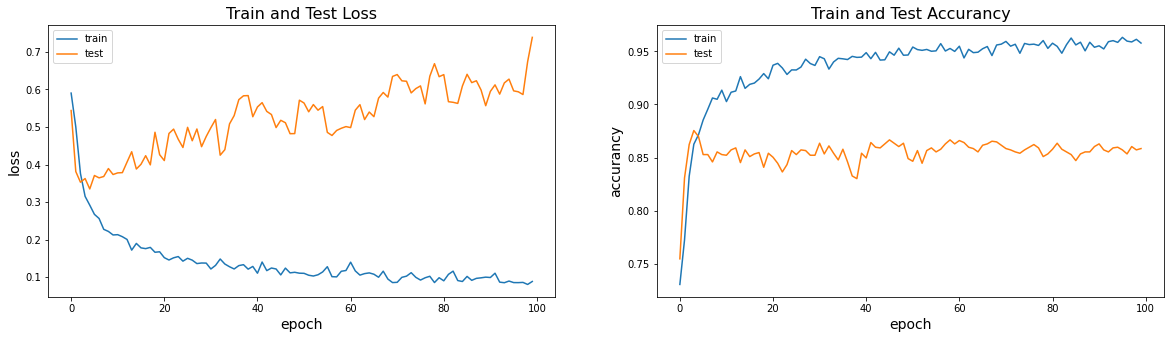

<Figure size 1440x360 with 0 Axes>

In [ ]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Train and Test Accurancy", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("accurancy", fontsize=14)
ax2.legend()
plt.show()

In [ ]:
model = FCNN()
model.load_state_dict(torch.load('fcnn_model_cv.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictions = (output>0.5).float()
        print('Accurancy:', accurancy(target, predictions))
        print('Precision:', precision(target, predictions))
        print('Recall:', recall(target, predictions))
        print('F1 Score', f1(target, predictions), '\n')

Accurancy: 0.869811320754717
Precision: 0.617948717948718
Recall: 0.8060200668896321
F1 Score 0.6995645863570391 



In [ ]:
test = ['badacze zwrócili uwagę na to że żółwie krokodyle i salamandry mają szczególnie niski wskaźnik starzenia się i wydłużoną żywotność jak na swoje rozmiary czemu to zawdzięczają u niektórych gatunków żółwi kluczową rolę w braku starzenia biologicznego odgrywa twarda skorupa dlaczego to proste daje zwierzęciu niezawodną ochronę przed czynnikami zewnętrznymi naukowcy podkreślają że zrozumienie powolnego starzenia się u zwierząt może pomóc lepiej zrozumieć starzenie się ludzi pomoże również opracować strategie ochrony gadów i płazów zagrożonych wyginięciem']
test = remove_stop_words(test)
print(test)
test_vector = count_vectorizer.transform(test)

with torch.no_grad():
      data = torch.Tensor(test_vector.todense()).cuda()
      output = model(data)
print(output)
print((output>0.5).float())

['badacze zwrócili uwagę żółwie krokodyle salamandry szczególnie niski wskaźnik starzenia wydłużoną żywotność rozmiary zawdzięczają niektórych gatunków żółwi kluczową rolę braku starzenia biologicznego odgrywa twarda skorupa proste daje zwierzęciu niezawodną ochronę czynnikami zewnętrznymi naukowcy podkreślają zrozumienie powolnego starzenia zwierząt pomóc lepiej zrozumieć starzenie ludzi pomoże opracować strategie ochrony gadów płazów zagrożonych wyginięciem']
tensor([[0.3075, 0.0706, 0.5812, 0.3926, 0.1554, 0.4355]], device='cuda:0')
tensor([[0., 0., 1., 0., 0., 0.]], device='cuda:0')


### OneVsAll - TF-IDF Vectorizer

In [ ]:
class FCNN2(nn.Module):
    def __init__(self):
        super(FCNN2, self).__init__()
        self.linear1 = nn.Linear(454654, 800)
        self.linear2 = nn.Linear(800, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 6)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        y_pred = torch.sigmoid(y_pred)
        return y_pred

In [ ]:
train_dataset = TensorDataset(torch.FloatTensor(train_vectors_tfidf.todense()), torch.FloatTensor(y_train.values))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(test_vectors_tfidf.todense()), torch.FloatTensor(y_test.values))
test_loader = DataLoader(test_dataset, batch_size=265, shuffle=False)

In [ ]:
model = FCNN2()
model.cuda()

epochs = 100
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
#writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0
  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += accurancy(target, (output>0.5).float())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    #writer.add_scalar("Loss/train", train_loss, epoch)
    #writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += accurancy(target, (output>0.5).float())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), 'fcnn_model_tfidf.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    #writer.add_scalar("Loss/test", test_loss, epoch)
    #writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

#writer.flush()
#writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 0.6328832805156708, Accuracy: 0.6467225609756098
Test Avg. loss: 0.6637463569641113, Accuracy: 0.7547169811320755
################## EPOCH 2 ##################
Train Avg. loss: 0.5808085560798645, Accuracy: 0.7367123983739837
Test Avg. loss: 0.6119886636734009, Accuracy: 0.7547169811320755
################## EPOCH 3 ##################
Train Avg. loss: 0.5588210880756378, Accuracy: 0.7465066056910568
Test Avg. loss: 0.5908386707305908, Accuracy: 0.7547169811320755
################## EPOCH 4 ##################
Train Avg. loss: 0.511969730257988, Accuracy: 0.7636623475609757
Test Avg. loss: 0.5542457103729248, Accuracy: 0.7547169811320755
################## EPOCH 5 ##################
Train Avg. loss: 0.44053045511245725, Accuracy: 0.7949885670731709
Test Avg. loss: 0.5327393412590027, Accuracy: 0.7345911949685534
################## EPOCH 6 ##################
Train Avg. loss: 0.3778404831886292, Accuracy: 0.8293762703252033
Tes

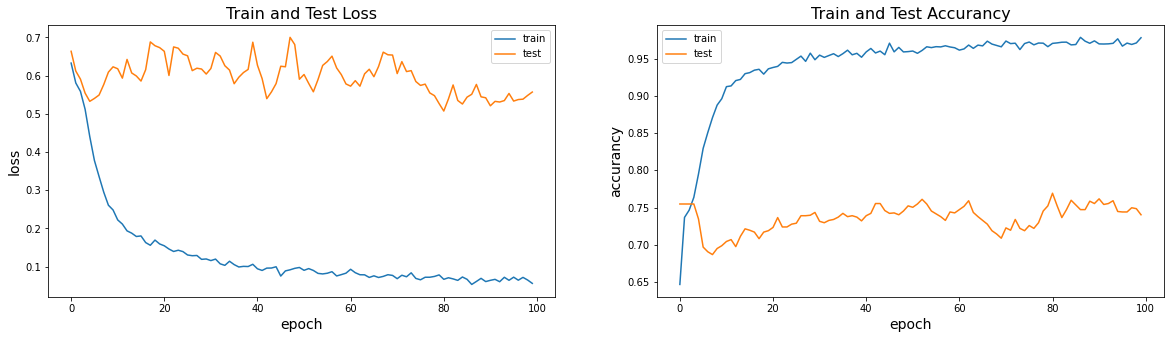

<Figure size 1440x360 with 0 Axes>

In [ ]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Train and Test Accurancy", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("accurancy", fontsize=14)
ax2.legend()
plt.show()

In [ ]:
model = FCNN2()
model.load_state_dict(torch.load('fcnn_model_tfidf.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictions = (output>0.5).float()
        print('Accurancy:', accurancy(target, predictions))
        print('Precision:', precision(target, predictions))
        print('Recall:', recall(target, predictions))
        print('F1 Score', f1(target, predictions), '\n')

Accurancy: 0.769182389937107
Precision: 0.6820512820512821
Recall: 0.5225933202357563
F1 Score 0.5917686318131256 



In [ ]:
test = ['badacze zwrócili uwagę na to że żółwie krokodyle i salamandry mają szczególnie niski wskaźnik starzenia się i wydłużoną żywotność jak na swoje rozmiary czemu to zawdzięczają u niektórych gatunków żółwi kluczową rolę w braku starzenia biologicznego odgrywa twarda skorupa dlaczego to proste daje zwierzęciu niezawodną ochronę przed czynnikami zewnętrznymi naukowcy podkreślają że zrozumienie powolnego starzenia się u zwierząt może pomóc lepiej zrozumieć starzenie się ludzi pomoże również opracować strategie ochrony gadów i płazów zagrożonych wyginięciem']
test = remove_stop_words(test)
print(test)
test_vector = vectorizer.transform(test)

with torch.no_grad():
      data = torch.Tensor(test_vector.todense()).cuda()
      output = model(data)
print((output>0.5).float())

preds = [0 if i < 0 else i for i in output[0]]
preds = torch.Tensor(preds)
categories = ['Historia', 'Kosmos', 'Ludzie', 'Nauka', 'Odkrycia', 'Przyroda']
while torch.max(preds)>0:
  idx = torch.argmax(preds)
  print('{0}: {1:.2f}%'.format(categories[idx], preds[idx]))
  preds[idx] = 0.0

['badacze zwrócili uwagę żółwie krokodyle salamandry szczególnie niski wskaźnik starzenia wydłużoną żywotność rozmiary zawdzięczają niektórych gatunków żółwi kluczową rolę braku starzenia biologicznego odgrywa twarda skorupa proste daje zwierzęciu niezawodną ochronę czynnikami zewnętrznymi naukowcy podkreślają zrozumienie powolnego starzenia zwierząt pomóc lepiej zrozumieć starzenie ludzi pomoże opracować strategie ochrony gadów płazów zagrożonych wyginięciem']
tensor([[0., 0., 0., 1., 1., 0.]], device='cuda:0')
Odkrycia: 0.88%
Nauka: 0.54%
Przyroda: 0.49%
Historia: 0.33%
Ludzie: 0.10%
Kosmos: 0.05%
